# Imports and File Reads

In [116]:
import pandas as pd
import numpy as np
from dataprep.eda import create_report, plot_correlation
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [117]:
# Rename filepath prefix for your respective folder hierarchies
filepath_prefix = 'dataset\\'

df_airbnb_users = pd.read_csv(f'{filepath_prefix}train_users_2.csv')
df_sessions = pd.read_csv(f'{filepath_prefix}sessions.csv')
df_countries = pd.read_csv(f'{filepath_prefix}countries.csv')
df_age_bkts = pd.read_csv(f'{filepath_prefix}age_gender_bkts.csv')


# Exploratory Data Analysis

## Age Bucket Distribution
Obtained from https://www.kaggle.com/code/asmaamohy/airbnb-eda

C:\Users\pawan\AppData\Local\Temp\ipykernel_22560\4040025584.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)


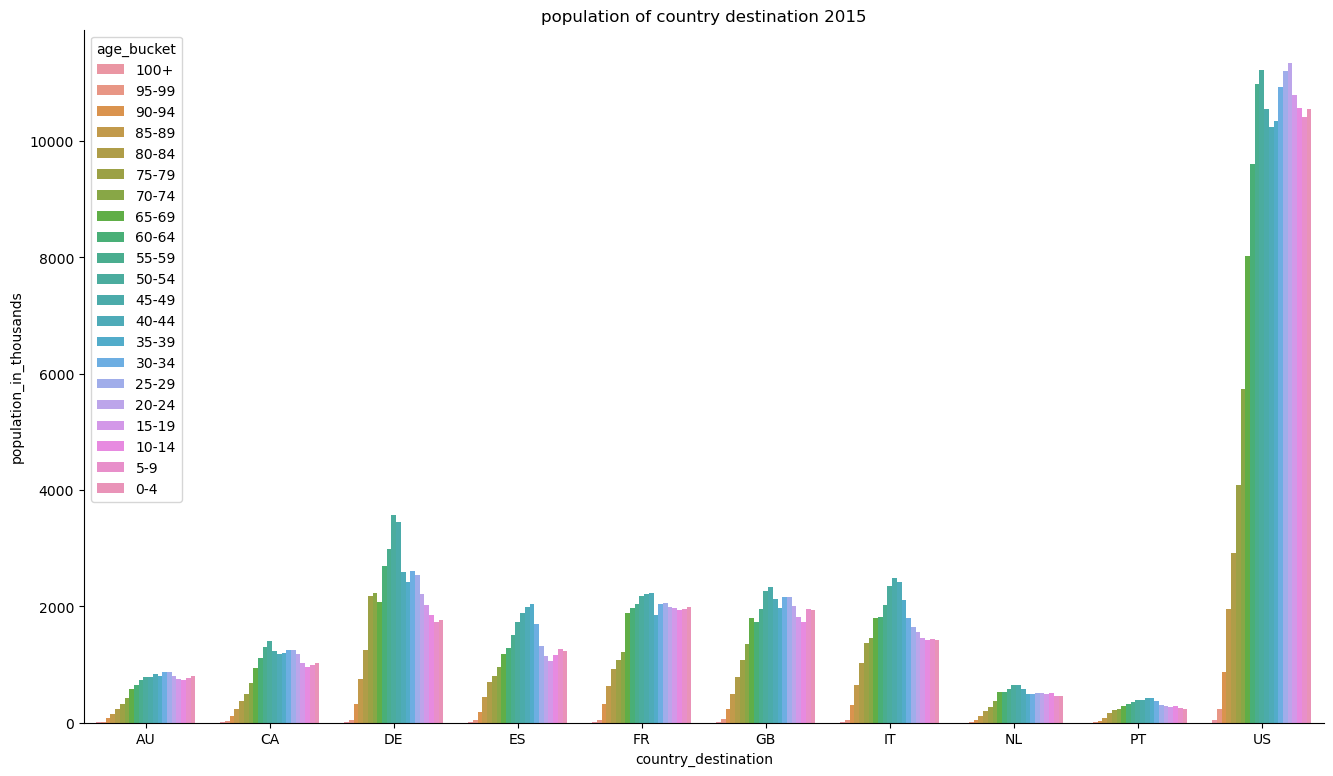

In [118]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)
plt.title('population of country destination 2015')
sns.despine()

## First Device vs Destination Country

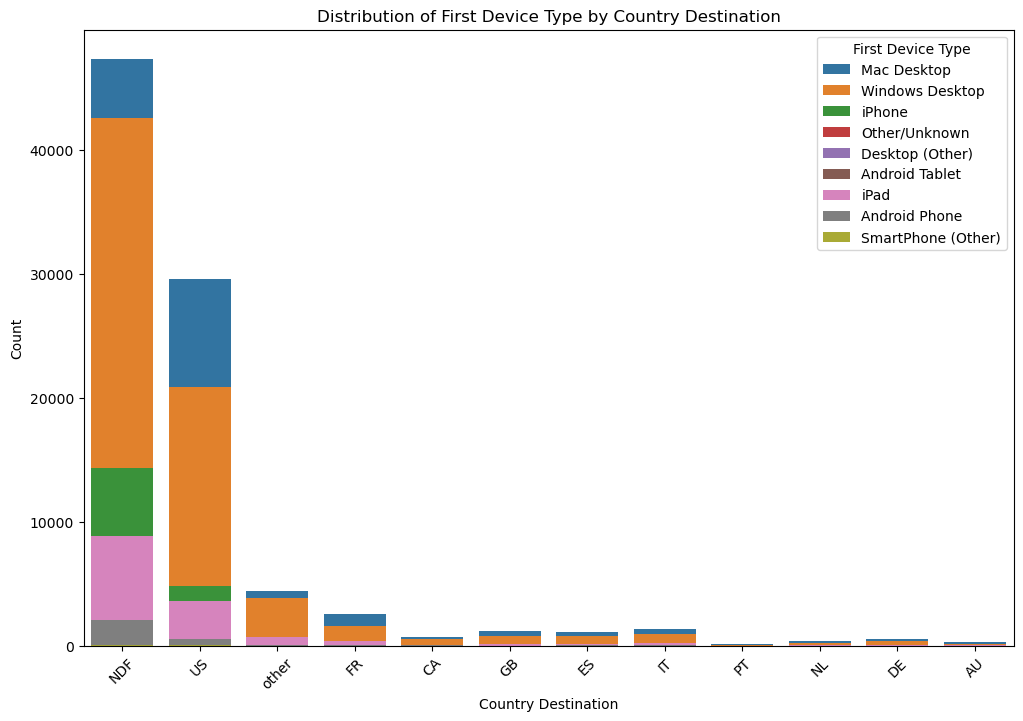

In [119]:
# Assuming df_train_users is your DataFrame
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=df_airbnb_users, x='country_destination', hue='first_device_type', dodge=False, ax=ax)

ax.set_title('Distribution of First Device Type by Country Destination')
ax.set_ylabel('Count')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type')

plt.show()

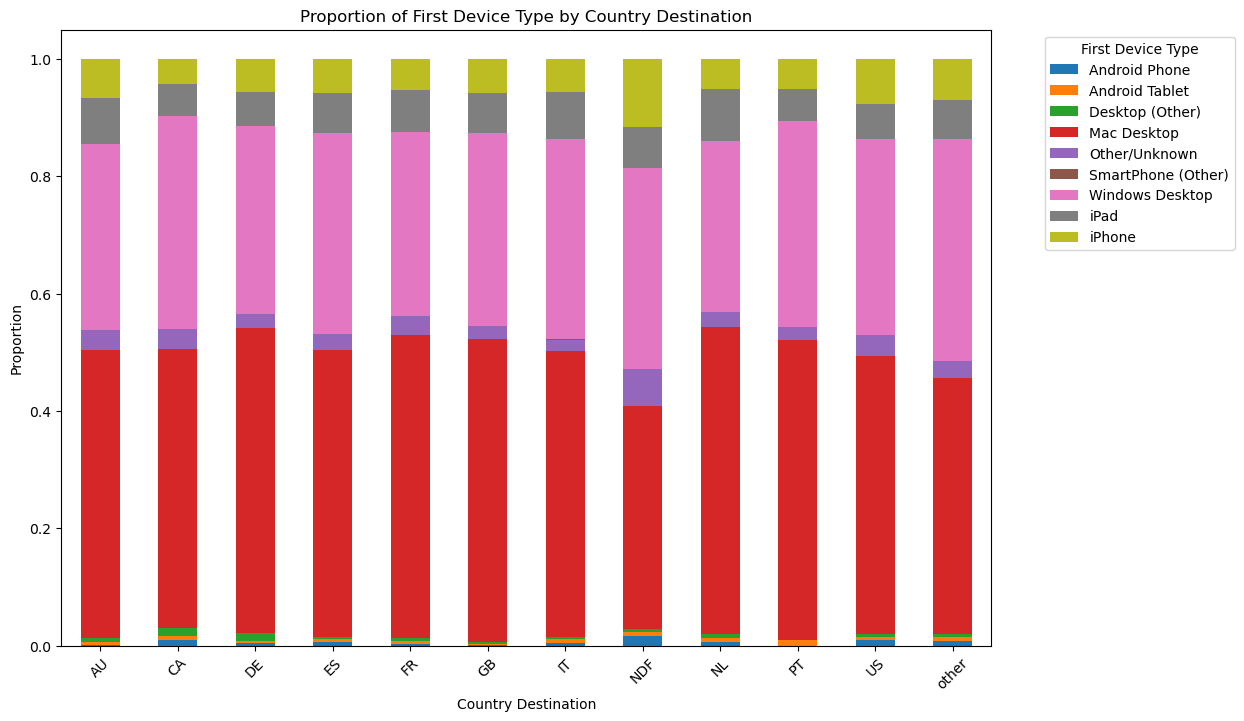

In [120]:
# Assuming df_train_users is your DataFrame
# Step 1: Calculate proportions
proportions = df_airbnb_users.groupby(['country_destination', 'first_device_type']).size().reset_index(name='count')
total_counts = df_airbnb_users['country_destination'].value_counts().reset_index()
total_counts.columns = ['country_destination', 'total_count']

proportions = proportions.merge(total_counts, on='country_destination')
proportions['proportion'] = proportions['count'] / proportions['total_count']

# Step 2: Create a pivot table
pivot_df = proportions.pivot_table(index='country_destination', columns='first_device_type', values='proportion', fill_value=0)

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Proportion of First Device Type by Country Destination')
ax.set_ylabel('Proportion')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<Axes: xlabel='age'>

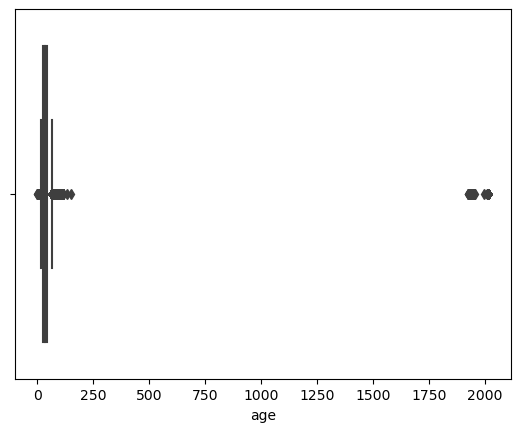

In [121]:
sns.boxplot(data=df_airbnb_users, x='age')

# Data Cleaning

In [122]:
df_airbnb_cleaned = df_airbnb_users.copy()

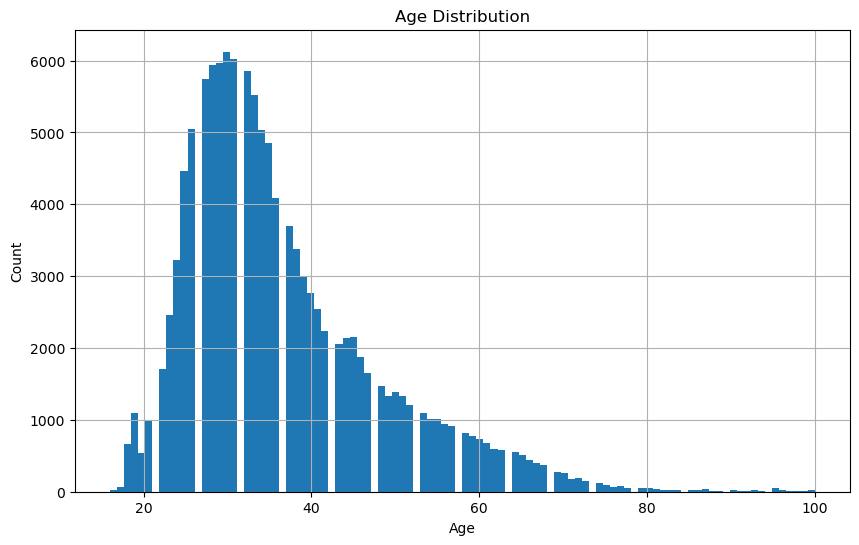

count    123079.000000
mean         36.569236
std          11.703130
min          16.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64


In [123]:
# Adjust the weird ages. Seems like there are some years added to the age

ages = df_airbnb_cleaned['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
df_airbnb_cleaned['age'] = ages

# Drop Ages < 18, it is AirBnB policy that minimum age of users should be 18

df_airbnb_cleaned = df_airbnb_cleaned[df_airbnb_cleaned['age'] >= 18]

In [124]:
df_airbnb_cleaned.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         55781
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     1960
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [125]:
# Drop NA
df_airbnb_cleaned['first_affiliate_tracked'] = df_airbnb_cleaned['first_affiliate_tracked'].fillna('Unknown')
df_airbnb_cleaned = df_airbnb_users.dropna()
df_airbnb_cleaned.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [126]:
# Calculate the total session time per user ID
total_session_time_per_user = (df_sessions.groupby('user_id')['secs_elapsed'].sum().reset_index())

# Merge the total session time with the df_train using the correct column names
df_airbnb_cleaned = pd.merge(df_airbnb_cleaned, total_session_time_per_user, left_on='id', right_on='user_id', how='left')

# Rename the column to be more descriptive
df_airbnb_cleaned.rename(columns={'secs_elapsed': 'total_session_time'}, inplace=True)

# Drop the redundant 'user_id' column
df_airbnb_cleaned.drop('user_id', axis=1, inplace=True)

# Data Processing and Feature Adjustments

In [127]:
df_airbnb_cleaned.fillna(value={'total_session_time':0}, inplace=True)

In [128]:
def get_month_diff (date, today):
    date = pd.to_datetime(date)
    return (relativedelta(date, today).years * 12 + relativedelta(date, today).months) * -1

today = datetime.today()
df_airbnb_cleaned['account_age_months'] = df_airbnb_cleaned['date_account_created'].apply(lambda date: get_month_diff(date, today))
df_airbnb_cleaned['first_booking_months'] = df_airbnb_cleaned['date_first_booking'].apply(lambda date: get_month_diff(date, today))

df_airbnb_cleaned.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_session_time,account_age_months,first_booking_months
0,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,0.0,164,166
1,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0.0,150,141
2,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,0.0,165,171
3,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,0.0,173,173
4,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,0.0,173,173


# Feature Importance and Correlation

In [129]:
#Extract numerical and categorical columns

categorical_features = df_airbnb_cleaned.select_dtypes(include='object').columns
numeric_features = df_airbnb_cleaned.select_dtypes(include=['int64', 'float64']).columns

In [130]:
# Perform ANOVA test to find associal between numerical features and country_destination

destinations = df_airbnb_cleaned['country_destination'].unique()

for numerical_feature in numeric_features:  
    arrays = [df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] == country][numerical_feature] for country in destinations]
    f_stat, p_value = f_oneway(*arrays)
    print(f'ANOVA F-statistic for feature {numerical_feature}: {f_stat}, p-value: {p_value}')

ANOVA F-statistic for feature timestamp_first_active: 20.08651427801075, p-value: 1.2206801464135887e-37
ANOVA F-statistic for feature age: 0.48992801559333016, p-value: 0.8977965530601025
ANOVA F-statistic for feature signup_flow: 12.086432562141015, p-value: 3.54008214760169e-21
ANOVA F-statistic for feature total_session_time: 3.772739547060228, p-value: 4.246919673867252e-05
ANOVA F-statistic for feature account_age_months: 26.455581719356932, p-value: 5.970378744547603e-51
ANOVA F-statistic for feature first_booking_months: 31.32083649450973, p-value: 3.513854314288255e-61


Cramers_V Interpretation Scale
* 0.00 to 0.10: Negligible association
* 0.10 to 0.20: Weak association
* 0.20 to 0.40: Moderate association
* 0.40 to 0.60: Relatively strong association
* 0.60 to 0.80: Strong association
* 0.80 to 1.00: Very strong association

In [131]:
# Explore how the activity is correlated with all the other variables 

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for categorical_feature in categorical_features:
    cramers_v_result = cramers_v(df_airbnb_cleaned['country_destination'], df_airbnb_cleaned[categorical_feature])
    print(f"Cramers_V output for feature {categorical_feature} = {cramers_v_result}")

C:\Users\pawan\AppData\Local\Temp\ipykernel_22560\378708506.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


Cramers_V output for feature id = inf
Cramers_V output for feature date_account_created = 0.04163208387799076
Cramers_V output for feature date_first_booking = 0.053403217413453045
Cramers_V output for feature gender = 0.03226014432807613
Cramers_V output for feature signup_method = 0.012151460393875553
Cramers_V output for feature language = 0.021124698432408825
Cramers_V output for feature affiliate_channel = 0.029262149791984726
Cramers_V output for feature affiliate_provider = 0.020463733939257458
Cramers_V output for feature first_affiliate_tracked = 0.015832562305249983
Cramers_V output for feature signup_app = 0.030688821460577383
Cramers_V output for feature first_device_type = 0.02214870711934843
Cramers_V output for feature first_browser = 0.007699147095242534
Cramers_V output for feature country_destination = 1.0


# Modeling

## Ensemble Classifier

## K-Means

In [132]:
df_kmeans = df_airbnb_cleaned.drop(columns=['country_destination', 'id', 'date_account_created','date_first_booking'])

In [133]:
# Scale the numerical columns data for k-means clustering
numeric_features = df_kmeans.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

# Apply StandardScaler to numerical columns
df_kmeans[numeric_features] = scaler.fit_transform(df_kmeans[numeric_features])

# One Hot Encode
categorical_features = df_kmeans.select_dtypes(include='object').columns

df_kmeans_encoded = pd.get_dummies(df_kmeans, columns=categorical_features, drop_first=True)
display(df_kmeans_encoded.info())

display(df_kmeans_encoded.dtypes)

# Use PCA to reduce dimensionality

pca = PCA(0.95)
df_kmeans_pca = pca.fit_transform(df_kmeans_encoded)

# Just naming cleanliness ;)
df_kmeans_train = df_kmeans_pca

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68171 entries, 0 to 68170
Columns: 107 entries, timestamp_first_active to first_browser_Yandex.Browser
dtypes: float64(6), uint8(101)
memory usage: 10.2 MB


None

timestamp_first_active            float64
age                               float64
signup_flow                       float64
total_session_time                float64
account_age_months                float64
                                   ...   
first_browser_Sogou Explorer        uint8
first_browser_Stainless             uint8
first_browser_TenFourFox            uint8
first_browser_TheWorld Browser      uint8
first_browser_Yandex.Browser        uint8
Length: 107, dtype: object

In [134]:
def kmeans_execution(df, num_clusters):
    # Create models & store labels for different number of clusters
    model = KMeans(n_clusters = num_clusters, n_init='auto', random_state = 0) # Create KMeans object \
    #kmeans = MiniBatchKMeans(n_clusters=k, random_state=716, batch_size=1000)
    model.fit(df) # Apply to the data
    labels = model.labels_ # Capture K-Means labels
    distortion = model.inertia_ # Used for elbow method
    silhouette = silhouette_score(df, labels)
    centers = model.cluster_centers_
    return {
        'model' : model,
        'centers' : centers,
        'labels' : labels,
        'distortion' : distortion,
        'silhouette_score' : silhouette
    }
    
k_means_cluster_results = {}
num_clusters_range = range(3, 13)

for cluster in num_clusters_range:
    k_means_cluster_results[cluster] = kmeans_execution(df_kmeans_train, cluster)
    print(f"Silhouette score for {cluster} clusters = {k_means_cluster_results[cluster]['silhouette_score']}")

Silhouette score for 3 clusters = 0.27262849847228693
Silhouette score for 4 clusters = 0.19314863335579593
Silhouette score for 5 clusters = 0.20058016445114263
Silhouette score for 6 clusters = 0.1877039951481343
Silhouette score for 7 clusters = 0.18566516338000616
Silhouette score for 8 clusters = 0.19268352835148286
Silhouette score for 9 clusters = 0.19886674147265124
Silhouette score for 10 clusters = 0.18296858776930292
Silhouette score for 11 clusters = 0.17422958480009942


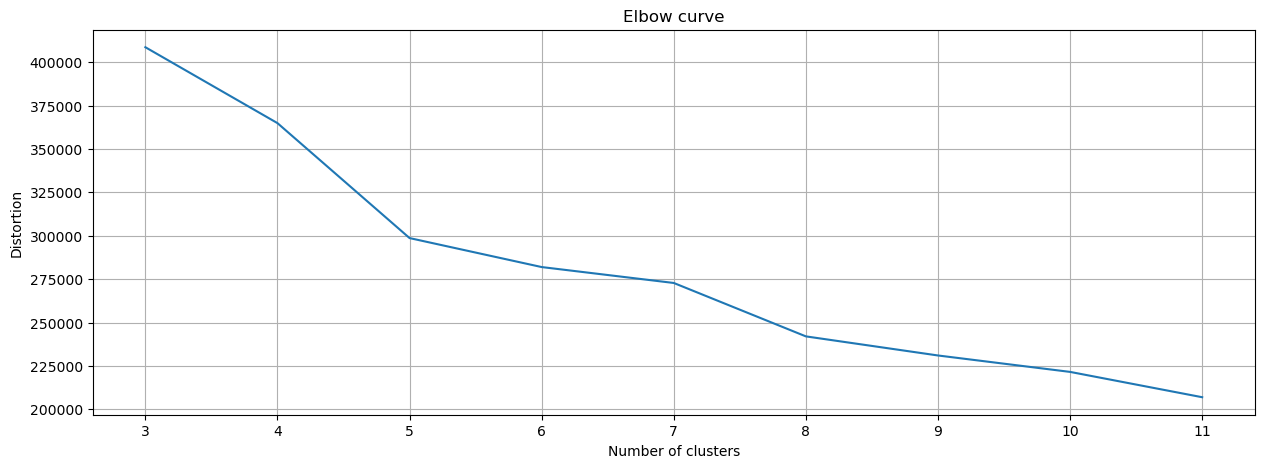

In [135]:
# Extracting distortions for different k values
distortions = [k_means_cluster_results[cluster]['distortion'] for cluster in num_clusters_range]

fig = plt.figure(figsize=(15, 5))
plt.plot(num_clusters_range, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

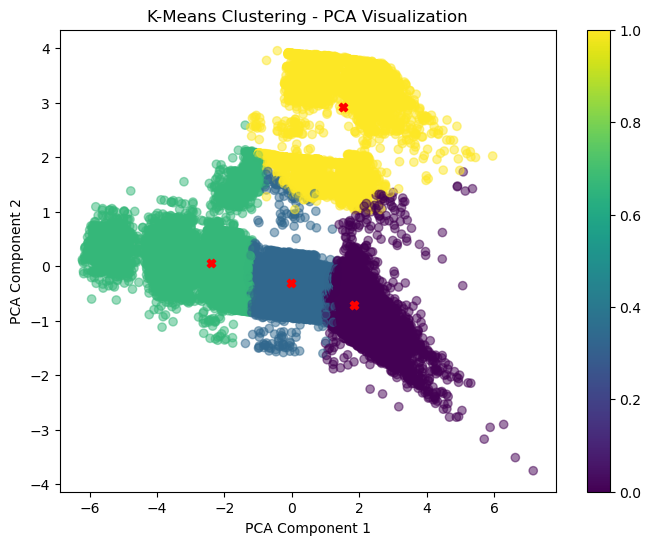

In [139]:
# Visualize clusters in PCA space
ideal_cluster_size = 4

plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_train[:, 0], df_kmeans_train[:, 1], c=k_means_cluster_results[ideal_cluster_size]['labels'], cmap='viridis', alpha=0.5, label='Data points')
plt.scatter(k_means_cluster_results[ideal_cluster_size]['centers'][:,0], k_means_cluster_results[ideal_cluster_size]['centers'][:,1], c='red', marker='X', label='Cluster Centers')
plt.title('K-Means Clustering - PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()